# Energy generation prediction 

In [109]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm.notebook import tqdm as tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

In [110]:
print(torch.__version__)

1.13.1+cu116


## Exploratory Data Analysis (EDA)

In [111]:
# Define data root directory
data_dir = "./data"
print(os.listdir(data_dir))

['Demand for United States Lower 48 (region) hourly - UTC time.csv']


In [112]:
df = pd.read_csv(os.path.join(data_dir, "/content/data/Demand for United States Lower 48 (region) hourly - UTC time.csv"))

In [113]:
df.head()

,date,megawatthours
0,2015-07-01 05:00:00,162827
1,2015-07-01 06:00:00,335153
2,2015-07-01 07:00:00,333837
3,2015-07-01 08:00:00,398386
4,2015-07-01 09:00:00,388954


In [114]:
df.shape

(58936, 2)

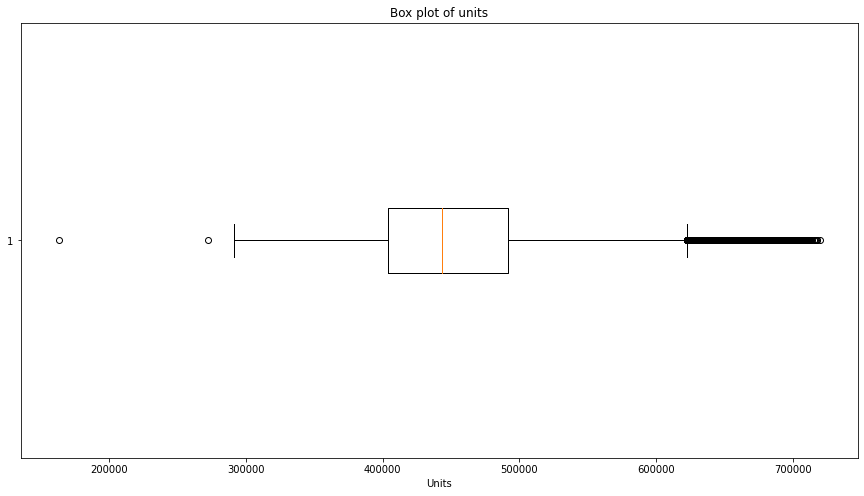

In [115]:
# Select the "units" column
units = df['megawatthours']

# Create a new figure with desired size
fig = plt.figure(figsize=(15, 8))

# Create a box plot
plt.boxplot(units, vert=False)

# Add plot title and axis labels
plt.title('Box plot of units')
plt.xlabel('Units')
plt.show()


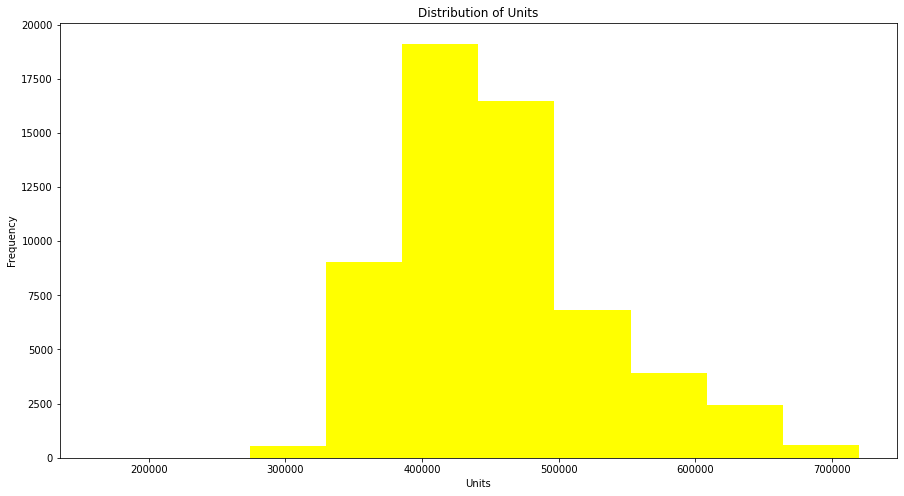

In [116]:
# Create a new figure with desired size
fig = plt.figure(figsize=(15, 8))

# Plot a histogram of the "units" column
plt.hist(df["megawatthours"], color='yellow')

# Add axis labels and title
plt.xlabel("Units")
plt.ylabel("Frequency")
plt.title("Distribution of Units")

# Show the plot
plt.show()


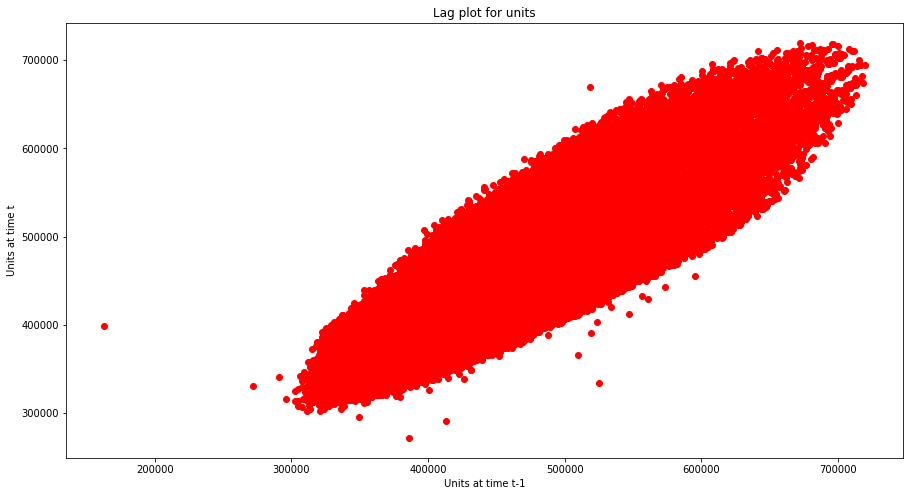

In [117]:
# Select only the "units" column
units = df['megawatthours']
# Create a new figure with desired size
fig = plt.figure(figsize=(15, 8))
# Create a lag plot with a lag of 1
pd.plotting.lag_plot(units, lag=3, c = 'red')

# Add plot title and axis labels
plt.title('Lag plot for units')
plt.xlabel('Units at time t-1')
plt.ylabel('Units at time t')

plt.show()


In [118]:
df.isnull()

,date,megawatthours
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
58931,False,False
58932,False,False
58933,False,False
58934,False,False


## Create training instances by moving sliding window

In [119]:
def move_sliding_window(data, window_size, inputs_cols_indices, label_col_index):
    """
    data: numpy array including data
    window_size: size of window
    inputs_cols_indices: col indices to include
    """

    # (# instances created by movement, seq_len (timestamps), # features (input_len))
    inputs = np.zeros((len(data) - window_size, window_size, len(inputs_cols_indices)))
    labels = np.zeros(len(data) - window_size)

    for i in range(window_size, len(data)):
        inputs[i - window_size] = data[i - window_size : i, inputs_cols_indices]
        labels[i - window_size] = data[i, label_col_index]
    inputs = inputs.reshape(-1, window_size, len(inputs_cols_indices))
    labels = labels.reshape(-1, 1)
    print(inputs.shape, labels.shape)

    return inputs, labels

## Integrate files to build the training set


In [120]:
label_col_index = 0  # consumption as label to predict
inputs_cols_indices = range(
    5
)  # use (consumption, hour, dayofweek, month, dayofyear) columns as features

# Define window_size period and split inputs/labels
window_size = 90

# The scaler objects will be stored in this dictionary so that our output test data from the model can be re-scaled during evaluation
label_scalers = {}

train_x = []
test_x = {}
test_y = {}

# Skipping the files we're not using
processing_files = [
    file for file in os.listdir(data_dir) if os.path.splitext(file)[1] == ".csv"
]

num_files_for_dataset = 4

for file in tqdm_notebook(processing_files[:num_files_for_dataset]):
    print(f"Processing {file} ...")
    # Store csv file in a Pandas DataFrame
    df = pd.read_csv(os.path.join(data_dir, file), parse_dates=["date"])

    # Processing the time data into suitable input formats
    df["hour"] = df.apply(lambda x: x["date"].hour, axis=1)
    df["dayofweek"] = df.apply(lambda x: x["date"].dayofweek, axis=1)
    df["month"] = df.apply(lambda x: x["date"].month, axis=1)
    df["dayofyear"] = df.apply(lambda x: x["date"].dayofyear, axis=1)
    df = df.sort_values("date").drop("date", axis=1)

    # Scaling the input data
    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df.values)

    # Obtaining the scaler for the labels(usage data) so that output can be
    # re-scaled to actual value during evaluation
    label_sc.fit(df.iloc[:, label_col_index].values.reshape(-1, 1))
    label_scalers[file] = label_sc

    # Move the window
    inputs, labels = move_sliding_window(
        data,
        window_size,
        inputs_cols_indices=inputs_cols_indices,
        label_col_index=label_col_index,
    )

    # CONCAT created instances from all .csv files.
    # Split data into train/test portions and combining all data from different files into a single array
    test_portion = int(0.1 * len(inputs))
    if len(train_x) == 0:  # first iteration
        train_x = inputs[:-test_portion]
        train_y = labels[:-test_portion]
    else:
        train_x = np.concatenate((train_x, inputs[:-test_portion]))
        train_y = np.concatenate((train_y, labels[:-test_portion]))
    test_x[file] = inputs[-test_portion:]
    test_y[file] = labels[-test_portion:]

  0%|          | 0/1 [00:00<?, ?it/s]

Processing Demand for United States Lower 48 (region) hourly - UTC time.csv ...
(58846, 90, 5) (58846, 1)


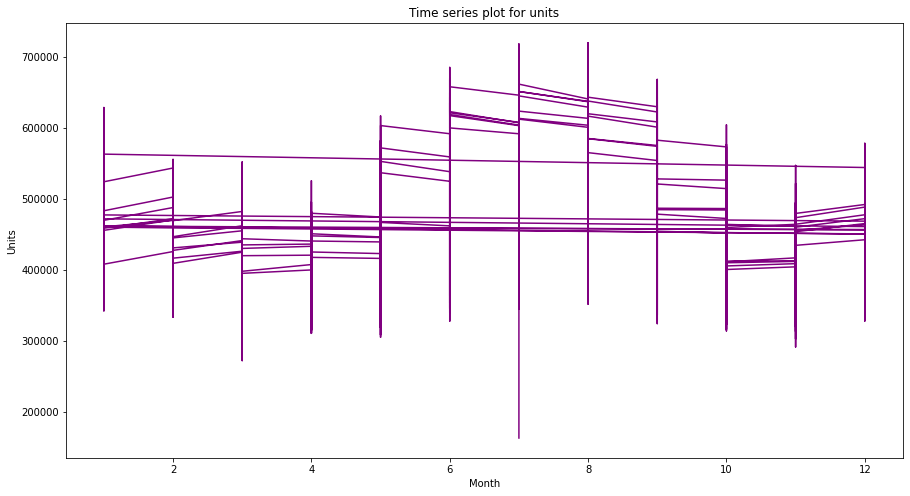

In [121]:
# Create a new DataFrame with "month" as the index and keep the original intact
df_indexed = df.set_index('month', drop=False)

# Select only the "units" column from the new indexed DataFrame
units = df_indexed['megawatthours']

# Create a new figure with desired size
fig = plt.figure(figsize=(15, 8))

# Create a time series plot
plt.plot(units, c='purple')

# Add plot title and axis labels
plt.title('Time series plot for units')
plt.xlabel('Month')
plt.ylabel('Units')
plt.show()

In [122]:
df.head()

,megawatthours,hour,dayofweek,month,dayofyear
0,162827,5,2,7,182
1,335153,6,2,7,182
2,333837,7,2,7,182
3,398386,8,2,7,182
4,388954,9,2,7,182


## Pytorch data loaders/generators

In [123]:
from sklearn.model_selection import train_test_split
batch_size =500
# Split data into training and validation sets
train_x, val_x, train_y, val_y = train_test_split(
    train_x, train_y, test_size=0.2, random_state=42
)

# Create TensorDatasets and DataLoaders for training and validation sets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

val_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [124]:
print(
    f"Train Size: {train_x.shape}, Batch Size: {batch_size}, # of iterations per epoch: {int(train_x.shape[0]/batch_size)}"
)

print(
    f"Validation Size: {val_x.shape}, Batch Size: {batch_size}, # of iterations per epoch: {int(val_x.shape[0]/batch_size)}"
)


Train Size: (42369, 90, 5), Batch Size: 500, # of iterations per epoch: 84
Validation Size: (10593, 90, 5), Batch Size: 500, # of iterations per epoch: 21


In [89]:
batch_size = 500

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))

# Drop the last incomplete batch
train_loader = DataLoader(
    train_data, shuffle=True, batch_size=batch_size, drop_last=True
)

In [90]:
print(
    f"Train Size: {train_x.shape}, Batch Size: {batch_size}, # of iterations per epoch: {int(train_x.shape[0]/batch_size)}"
)

Train Size: (52962, 90, 5), Batch Size: 500, # of iterations per epoch: 105


In [125]:
# release some memory
del train_x, train_y

In [126]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")

GPU is available


In [127]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:, -1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        # Initialze h_0, c_0 with zeros
        hidden = (
            weight.new(self.n_layers, batch_size, self.hidden_dim)
            .zero_()
            .to(device),  # h_0
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
        )
        return hidden

## Train and Save an LSTM model

In [128]:
def train(train_loader, val_loader, learn_rate, hidden_dim=256, n_layers=2, n_epochs=3, model_type="GRU", print_every=100):
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1

    # Instantiate the model
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []

    train_losses = []
    val_losses = []

    # Start training loop
    for epoch in range(1, n_epochs + 1):
        start_time = time.process_time()

        # Training loop
        h = model.init_hidden(batch_size)
        avg_loss = 0.0
        counter = 0
        for x, label in train_loader:
            counter += 1
            if model_type == "GRU":
                h = h.data
            elif model_type == "LSTM":
                h = tuple([e.data for e in h])

            model.zero_grad()
            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()

            avg_loss += loss.item()
            if counter % print_every == 0:
                print(
                    f"Epoch {epoch} - Step: {counter}/{len(train_loader)} - Average Loss for Epoch: {avg_loss/counter}"
                )

        current_time = time.process_time()
        train_losses.append(avg_loss / len(train_loader))
        print(f"Epoch {epoch}/{n_epochs} Done, Train Loss: {train_losses[-1]}")
        print(f"Time Elapsed for Epoch: {current_time-start_time} seconds")

        # Validation loop
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for x, label in val_loader:
                h = model.init_hidden(batch_size)
                if model_type == "GRU":
                    h = h.data
                elif model_type == "LSTM":
                    h = tuple([e.data for e in h])

                out, h = model(x.to(device).float(), h)
                loss = criterion(out, label.to(device).float())
                val_loss += loss.item()

            val_losses.append(val_loss / len(val_loader))
            print(f"Validation Loss: {val_losses[-1]}")

        model.train()

    # Plot the training and validation losses
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    print(f"Total Training Time: {sum(epoch_times)} seconds")
    return model

Starting Training of LSTM model
Epoch 1 - Step: 50/84 - Average Loss for Epoch: 0.1362090140208602
Epoch 1/20 Done, Train Loss: 0.08923884880329881
Time Elapsed for Epoch: 6.40486187700003 seconds
Validation Loss: 0.01781750638924894
Epoch 2 - Step: 50/84 - Average Loss for Epoch: 0.016280446257442235
Epoch 2/20 Done, Train Loss: 0.015544646874158866
Time Elapsed for Epoch: 6.409824940000021 seconds
Validation Loss: 0.01344027543174369
Epoch 3 - Step: 50/84 - Average Loss for Epoch: 0.012654119487851858
Epoch 3/20 Done, Train Loss: 0.011794087987038352
Time Elapsed for Epoch: 6.489643784000009 seconds
Validation Loss: 0.009905014453189713
Epoch 4 - Step: 50/84 - Average Loss for Epoch: 0.008671211982145906
Epoch 4/20 Done, Train Loss: 0.007543513379503219
Time Elapsed for Epoch: 6.663478113999986 seconds
Validation Loss: 0.004365993064961263
Epoch 5 - Step: 50/84 - Average Loss for Epoch: 0.0038000115333124995
Epoch 5/20 Done, Train Loss: 0.0035673277923792953
Time Elapsed for Epoch: 6

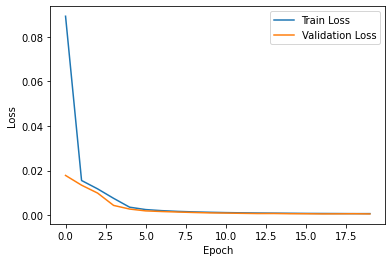

Total Training Time: 0 seconds


In [129]:
n_hidden = 256
n_layers = 2
n_epochs = 20
print_every = 50
lr = 0.0001
lstm_model = train(
    train_loader,
    val_loader=val_loader,
    learn_rate=lr,
    hidden_dim=n_hidden,
    n_layers=n_layers,
    n_epochs=n_epochs,
    model_type="LSTM",
    print_every=print_every,
)


In [131]:
torch.save(lstm_model.state_dict(), "./models/lstm_model.pt")

# Evaluating models


In [132]:
# move device to cpu for evaluation to avoid GPU memory run
device = "cpu"

## Load the LSTM model

In [133]:
hidden_dim = 256
input_dim = 5
output_dim = 1
n_layers = 2
lstm_model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
lstm_model.load_state_dict(torch.load("./models/lstm_model.pt"))

<All keys matched successfully>

In [134]:
# Move the model to the appropriate device
lstm_model.to(device)

LSTMNet(
  (lstm): LSTM(5, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

## Model Evaluation



In [135]:
def sMAPE(outputs, targets):
    sMAPE = (
        100
        / len(targets)
        * np.sum(np.abs(outputs - targets) / (np.abs(outputs + targets)) / 2)
    )
    return sMAPE

In [136]:
def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.process_time()
    # get data of test data for each state
    for file in test_x.keys():
        inputs = torch.from_numpy(np.array(test_x[file]))
        labels = torch.from_numpy(np.array(test_y[file]))

        h = model.init_hidden(inputs.shape[0])

        # predict outputs
        with torch.no_grad():
            out, h = model(inputs.to(device).float(), h)

        outputs.append(
            label_scalers[file]
            .inverse_transform(out.cpu().detach().numpy())
            .reshape(-1)
        )

        targets.append(
            label_scalers[file].inverse_transform(labels.numpy()).reshape(-1)
        )

    # Merge all files
    concatenated_outputs = np.concatenate(outputs)
    concatenated_targets = np.concatenate(targets)

    print(f"Evaluation Time: {time.process_time()-start_time}")
    print(f"sMAPE: {round(sMAPE(concatenated_outputs, concatenated_targets), 3)}%")

    # list of of targets/outputs for each state
    return outputs, targets, sMAPE

## Evaluate performance of LSTM

In [137]:
lstm_outputs, targets, lstm_sMAPE = evaluate(lstm_model, test_x, test_y, label_scalers)

Evaluation Time: 19.05969321200007
sMAPE: 0.578%


In [138]:
lstm_outputs

[array([594471.6 , 626426.2 , 638924.3 , ..., 447024.4 , 443901.47,
        439673.2 ], dtype=float32)]

In [139]:
targets

[array([574133., 596306., 614936., ..., 426496., 423393., 420157.])]

In [140]:
len(
    lstm_outputs
)  # list of predicted output file for each state (each element has a 1d array for that state)

1

In [141]:
states_list = list(test_x.keys())

In [142]:
states_list

['Demand for United States Lower 48 (region) hourly - UTC time.csv']

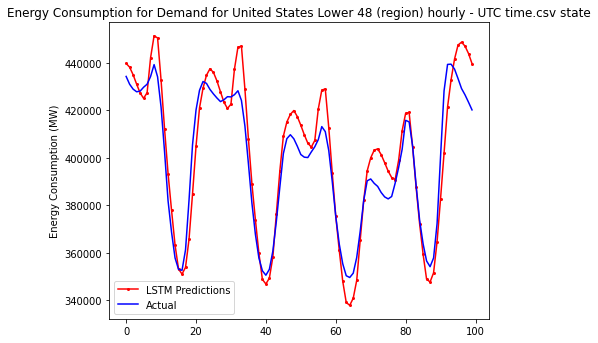

In [143]:
plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 1)
plt.plot(
    lstm_outputs[0][-100:], "-o", color="r", label="LSTM Predictions", markersize=2
)
plt.plot(targets[0][-100:], color="b", label="Actual")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[0]} state")
plt.legend()


